In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier

from scipy.stats import uniform, loguniform

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

In [133]:
# Clean up warnings for presentation

import warnings
warnings.filterwarnings("ignore")

In [183]:
combined = pd.read_csv('../data/combined_clean.csv')

In [184]:
# Set up X and y

X = combined['text']

y = combined['subreddit']

#### Review Count Vectorized Data

In [185]:
# Count vectorize data

stop_word_list = ['to', 'the', 'and', 'you', 'it', 'of', 'that', 'is', 'on', 'my', 'in', 'for', 'this', 'with', 
                  'but', 'me', 'not', 'have', 'just', 'if', 'so', 'like', 'or', 'are', 'be', 'what', 'was', 'your', 
                  'they', 'do', 'she', 'get', 'can', 'people', 'about', 'as', 'he', 'out', 'profile', 'how', 'up', 
                  'all', 'her', 'we', 'one', 'at', 'no', 'there', 'when', 'would', 'who', 'know', 'from',  'time', 
                  'them', 'think', 'more', 'some', 'had', 'an', 'good', 'someone', 'then', 'because', 'any', 'don',
                  're', 've', 'right', 'matches', 'why', 'first', 'really', 'see', 'want', 'even', 'women', 'been',
                 'im', 'dont', 'its', 'ive', 'only', 'date', 'now', 'youre', 'am', 'something', 'has']

cvec = CountVectorizer(stop_words = stop_word_list)

X_cv = cvec.fit_transform(X)

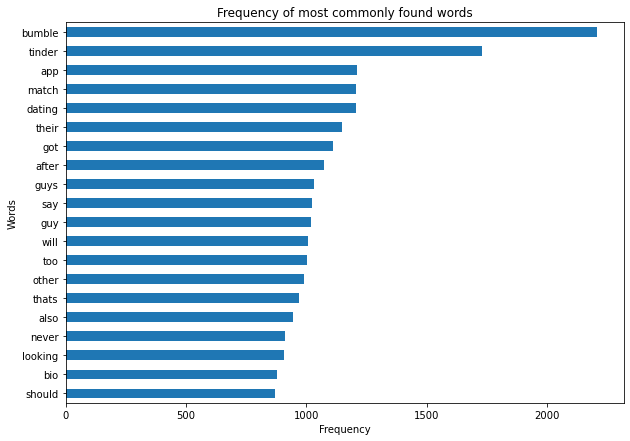

In [195]:
# Convert training data to dataframe

X_cv_df = pd.DataFrame(X_cv.todense(), columns = cvec.get_feature_names())

# Plot most frequent words

plt.figure(figsize = (10, 7))

X_cv_df.sum().sort_values().tail(20).plot(kind = 'barh')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of most commonly found words')
plt.savefig('../images/combined.png');

Create my own list of stop words based on frequency in the corpus: 'to', 'the', 'and', 'you', 'it', 'of', 'that', 'is', 'on', 'my', 'in', 'for', 'this', 'with', 'but', 'me', 'not', 'have', 'just', 'if', 'so', 'like', 'or', 'are', 'be', 'what', 'was', 'your', 'they', 'do', 'she', 'get', 'can', 'people', 'about', 'as', 'he', 'out', 'profile', 'how', 'up', 'all', 'her', 'we', 'one', 'at', 'no', 'there', 'when', 'would', 'who', 'know', 'from', 'time', 'them', 'think', 'more', 'some', 'had', 'an', 'good', 'someone', 'then', 'because', 'any', 'don', 're', 've', 'right', 'matches', 'why', 'first', 'really', 'see', 'want', 'even', 'women', 'been', 'im', 'dont', 'its', 'ive', 'only', 'date', 'now', 'youre', 'am', 'something', 'has'

In [6]:
# Create a dataframe to store model results

column_names = ['model', 'best_params', 'training_score', 'test_score']

model_df = pd.DataFrame(columns = column_names)

#### Set up Train/Test Split

In [187]:
# Set up train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#### Create Functions to View Model Results and Add to DataFrame

In [99]:
# Create function to view/store model results

def results(model):
    best_params = model.best_params_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f'Best parameters: {best_params}')
    print(f'Training score: {train_score}')
    print(f'Test score: {test_score}')


In [96]:
# Create function to add results to model df

def add_to_model(df, model, name):
    df = df.append({'model': name,
                'best_params': model.best_params_,
                'training_score': model.score(X_train, y_train),
                'test_score': model.score(X_test, y_test)},
                ignore_index = True)
    return df

#### Support Vector Model

In [209]:
# Create pipeline to instantiate models

pipe_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_word_list, ngram_range = (1, 2))),
    ('svc', SVC(kernel = 'poly', gamma = 'scale', degree = 2, shrinking = False, random_state = 42))
])

In [210]:
# Create parameters for pipeline

pipe_params_svc = {
    'cvec__max_features': Integer(10_000, 15_000),
    'cvec__min_df'      : Integer(2, 3),
    'cvec__max_df'      : Real(.9, .95),
    'svc__C'            : Real(1e-5, 1e+2, prior='log-uniform'),
    'svc__coef0'        : Real(0,1, prior='uniform') 
}

In [211]:
# Create bayes model to run SVC

bs_svc = BayesSearchCV(estimator = pipe_svc,
                       search_spaces = pipe_params_svc,
                       scoring = 'f1_weighted',
                       n_iter = 5,
                       cv = 5,
                       random_state = 42)

In [212]:
# Fit model to training data

bs_svc.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec',
                                         CountVectorizer(ngram_range=(1, 2),
                                                         stop_words=['to',
                                                                     'the',
                                                                     'and',
                                                                     'you',
                                                                     'it', 'of',
                                                                     'that',
                                                                     'is', 'on',
                                                                     'my', 'in',
                                                                     'for',
                                                                     'this',
                                                                     'with',
 

In [213]:
# View results of model

results(bs_svc)

Best parameters: OrderedDict([('cvec__max_df', 0.9406197994178681), ('cvec__max_features', 10859), ('cvec__min_df', 3), ('svc__C', 4.162492539230118), ('svc__coef0', 0.5230523280543836)])
Training score: 0.8823917078209427
Test score: 0.6838184451202158


In [214]:
# Append the results of this run to the model data frame

model_df = add_to_model(model_df, bs_svc, 'svc')

#### Bernoulli model

In [203]:
# Create pipeline to instantiate models

pipe_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_word_list)),
    ('nb', BernoulliNB())
])

In [204]:
# Set up pipeline parameters

pipe_params_nb = {
    'cvec__max_features': Integer(5_000, 10_000),
    'cvec__min_df'      : Integer(1, 3),
    'cvec__max_df'      : Real(.85, .95),
    'nb__alpha'         : Real(0.0001, 1.0)
}


In [205]:
# Create bayes model to run bernoulli

bs_nb = BayesSearchCV(estimator = pipe_nb,
                       search_spaces = pipe_params_nb,
                       scoring = 'f1_weighted',
                       n_iter = 50,
                       cv = 5,
                       random_state = 42)

In [206]:
# Fit training data to the model

bs_nb.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec',
                                         CountVectorizer(ngram_range=(2, 2),
                                                         stop_words=['to',
                                                                     'the',
                                                                     'and',
                                                                     'you',
                                                                     'it', 'of',
                                                                     'that',
                                                                     'is', 'on',
                                                                     'my', 'in',
                                                                     'for',
                                                                     'this',
                                                                     'with',
 

In [207]:
# View results of this run

results(bs_nb)

Best parameters: OrderedDict([('cvec__max_df', 0.95), ('cvec__max_features', 10000), ('cvec__min_df', 1), ('nb__alpha', 0.0001)])
Training score: 0.7313707683442104
Test score: 0.6041541711372016


In [152]:
# Append results to model data frame

model_df = add_to_model(model_df, bs_nb, 'bernoulli')

#### Random Forest Model

In [45]:
# Create pipeline to instantiate models

pipe_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_word_list)),
    ('rf', RandomForestClassifier())
])

In [154]:
# Set up pipeline parameters

pipe_params_rf = {
    'cvec__max_features': Integer(500, 5_000),
    'cvec__min_df'      : Integer(1, 5),
    'cvec__max_df'      : Real(.85, .95),
    'rf__n_estimators'  : Integer(100, 1_000),
    'rf__max_depth'     : Integer(1, 15) 
}

In [155]:
# Run bayes on random forest model

bs_rf = BayesSearchCV(estimator = pipe_rf,
                       search_spaces = pipe_params_rf,
                       scoring = 'f1_weighted',
                       n_iter = 50,
                       cv = 5,
                       random_state = 42)

In [156]:
# Fit training data to the model

bs_rf.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec',
                                         CountVectorizer(stop_words=['to',
                                                                     'the',
                                                                     'and',
                                                                     'you',
                                                                     'it', 'of',
                                                                     'that',
                                                                     'is', 'on',
                                                                     'my', 'in',
                                                                     'for',
                                                                     'this',
                                                                     'with',
                                                                     'but',
  

In [157]:
# View results of this run

results(bs_rf)

Best parameters: OrderedDict([('cvec__max_df', 0.95), ('cvec__max_features', 5000), ('cvec__min_df', 5), ('rf__max_depth', 15), ('rf__n_estimators', 1000)])
Training score: 0.7112335130355033
Test score: 0.6690577519057673


In [158]:
# Append results to model data frame

model_df = add_to_model(model_df, bs_rf, 'random_forest')

#### XG Boost

In [188]:
# Create pipeline to instantiate models

pipe_xg = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_word_list)),
    ('xg', XGBClassifier(eval_metric = 'logloss')),
])


In [189]:
# Set up pipeline parameters

pipe_params_xg = {
    'cvec__max_features': Integer(15_000, 18_000),
    'cvec__min_df'      : Integer(2, 8),
    'cvec__max_df'      : Real(.9, .99),
    'xg__n_estimators'  : Integer(100, 500),
    'xg__max_depth'     : Integer(2, 15) 
}


In [190]:
# Run bayes on the xg boost model

bs_xg = BayesSearchCV(estimator = pipe_xg,
                       search_spaces = pipe_params_xg,
                       scoring = 'f1_weighted',
                       n_iter = 50,
                       cv = 5,
                       random_state = 42)

In [191]:
# Fit the model to training data

bs_xg.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec',
                                         CountVectorizer(stop_words=['to',
                                                                     'the',
                                                                     'and',
                                                                     'you',
                                                                     'it', 'of',
                                                                     'that',
                                                                     'is', 'on',
                                                                     'my', 'in',
                                                                     'for',
                                                                     'this',
                                                                     'with',
                                                                     'but',
  

In [192]:
# View the results of this run

results(bs_xg)

Best parameters: OrderedDict([('cvec__max_df', 0.9), ('cvec__max_features', 18000), ('cvec__min_df', 2), ('xg__max_depth', 15), ('xg__n_estimators', 279)])
Training score: 0.8330595187757812
Test score: 0.693419656945338


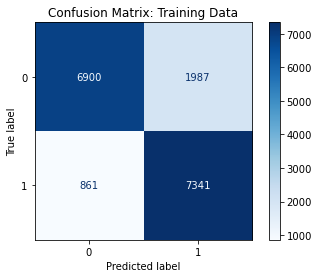

In [245]:
# Plot confusion matrix on results: training

plot_confusion_matrix(bs_xg.best_estimator_, X_train, y_train, cmap = 'Blues')
plt.title('Confusion Matrix: Training Data');

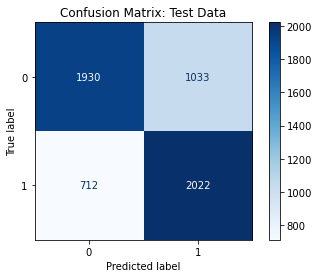

In [246]:
# Plot confusion matrix on results: test

plot_confusion_matrix(bs_xg.best_estimator_, X_test, y_test, cmap = 'Blues')
plt.title('Confusion Matrix: Test Data')
plt.savefig('../images/confusion_matrix_test');

In [193]:
# Append this data to the model data frame

model_df = add_to_model(model_df, bs_xg, 'xg_boost')

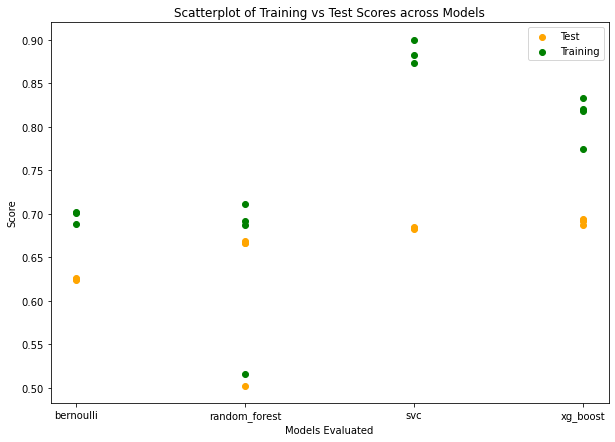

In [244]:
# Plot the results of the models

plt.figure(figsize = (10, 7))

plt.scatter(x = model_df['model'], y = model_df['test_score'], c = 'orange', label = 'Test')
plt.scatter(x = model_df['model'], y = model_df['training_score'], c = 'green', label = 'Training')
plt.title('Scatterplot of Training vs Test Scores across Models')
plt.xlabel('Models Evaluated')
plt.ylabel('Score')
plt.legend()
plt.savefig('../images/scores.png');

In [247]:
# Output all model results to csv

model_df.to_csv('../data/model_results.csv', index = False)